Parameters
===================

In [ ]:
batch_size = 1000 # number of all train image, batch size
latent_dim = 100
label_classes = 10
img_size = 28
channels = 1
N = 60000
epochs = 2

Packages
=================

In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd.variable import Variable
import seaborn as sns
import numpy as np

Dataset
============


In [2]:
from tensorflow.keras.datasets import mnist
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) = mnist.load_data()
print(f"x_train's shape is {X_train_numpy.shape}\n x_test's shape is {X_test_numpy.shape}\n \
y_train's shape is {Y_train_numpy.shape}\n y_test's shape is {Y_test_numpy.shape}")

x_train's shape is (60000, 28, 28)
 x_test's shape is (10000, 28, 28)
 y_train's shape is (60000,)
 y_test's shape is (10000,)


In [3]:
X_train = torch.div(torch.from_numpy(X_train_numpy).type(torch.FloatTensor), 127.5)[0:60003].cuda() - 1
X_train.size()

torch.Size([60000, 28, 28])

In [4]:
Y_train = torch.from_numpy(Y_train_numpy).type(torch.LongTensor).cuda()
Y_train.size()

torch.Size([60000])

Generator
=======================
input: torch [batch_size]  
output: img: [batch_size, channel, H, W]

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(label_classes, latent_dim) # a dictionary whose size = (n_classes * latent_dim)
        # self.noise = torch.FloatTensor(np.random.normal(0, 1, (label_classes, latent_dim)))
        self.linear = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(latent_dim, (int)(128 * (img_size / 4) ** 2)))
        ]))

        self.conv = nn.Sequential(OrderedDict([
            ('bn1', nn.BatchNorm2d(128)),
            ('us1', nn.Upsample(scale_factor=2)),
            ('conv1', nn.Conv2d(128, 128, 3, stride=1, padding=1)),
            ('bn2', nn.BatchNorm2d(128, 0.8)),
            ('lr1', nn.LeakyReLU(0.2, inplace=True)),
            ('us2', nn.Upsample(scale_factor=2)),
            ('conv2', nn.Conv2d(128, 64, 3, stride=1, padding=1)),
            ('bn3', nn.BatchNorm2d(64, 0.8)),
            ('lr2', nn.LeakyReLU(0.2, inplace=True)),
            ('conv3', nn.Conv2d(64, channels, 3, stride=1, padding=1)),
            ('th1', nn.Tanh())
        ]))

    def forward(self, x):
        x = torch.mul(self.label_emb(x), 
                torch.cuda.FloatTensor(
                    np.random.normal(0, 1, 
                                     (x.size()[0], latent_dim)))) # add noise, size = (batch, latent_dim)
        x = self.linear(x) # extend the dim
        x = x.view(x.size()[0], 128, (int)(img_size / 4), (int)(img_size / 4))
        x = self.conv(x)
        return x

In [ ]:
generator = Generator().cuda()
gen_labels = Variable(torch.cuda.LongTensor(np.random.randint(0, label_classes, batch_size)))
fake_image = generator(gen_labels)
fake_image.size()

Discriminator
======================
input image.size = (batch_size, channels, height, width)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
    
        def discriminator_block(in_channels, out_channels, bn=True):
            block = [nn.Conv2d(in_channels, out_channels, 3),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.1)]
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False), # img_size - 2
            *discriminator_block(16, 32), # img_size - 2
            *discriminator_block(32, 64), # img_size - 2
            *discriminator_block(64, 128), # img_size - 2
        )

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * (img_size - 8) ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * (img_size - 8) ** 2, label_classes), nn.Softmax(dim=1))

    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.view(x.size()[0], -1)
        validity = self.adv_layer(x)
        label = self.aux_layer(x)

        return validity, label

In [13]:
discriminator = Discriminator().cuda()
val, l = discriminator(fake_image)
print(f"{val.size()}, {l.size()}")

torch.Size([32, 1]), torch.Size([32, 10])


Implement
=======================

parameters
---------------

In [7]:
batch_size = 1000 # number of all train image, batch size
latent_dim = 100
label_classes = 10
img_size = 28
channels = 1
N = 60000
epochs = 200

loss
----------------

In [8]:
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

instance
------------------

In [9]:
discriminator = Discriminator().cuda()
generator = Generator().cuda()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)
generator_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)

train
-------------------

In [10]:
def show_generate_image(x_torch, l_torch):
    x = x_torch[0:8, 0:channels, 0:img_size, 0:img_size].cpu().detach().numpy().reshape((8, img_size, img_size))
    fig, ax = plt.subplots(1, 8, figsize=(17,17))
    for i, img in enumerate(x):
        ax[i].imshow(img)
        ax[i].set_title(f"{l_torch[i].item()}")
    plt.show()


epoch is 19: discriminator loss is         1.1400513648986816, generator loss is 2.073979377746582


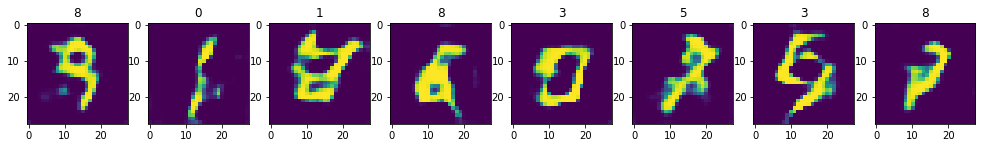


epoch is 39: discriminator loss is         1.1228899955749512, generator loss is 1.5847578048706055


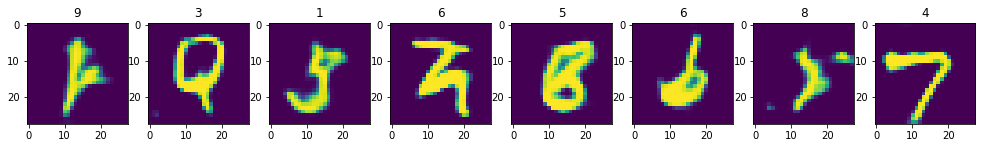


epoch is 59: discriminator loss is         1.0361480712890625, generator loss is 1.587961196899414


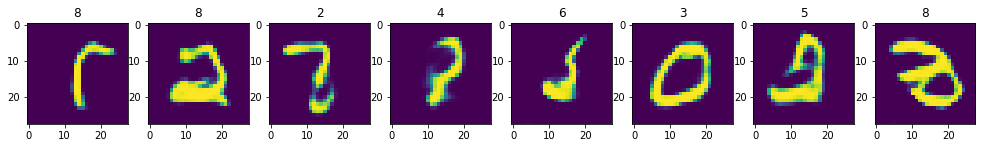


epoch is 79: discriminator loss is         1.092836618423462, generator loss is 1.2577300071716309


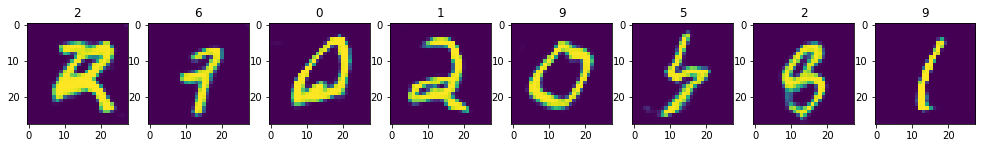


epoch is 99: discriminator loss is         1.0736021995544434, generator loss is 1.3586081266403198


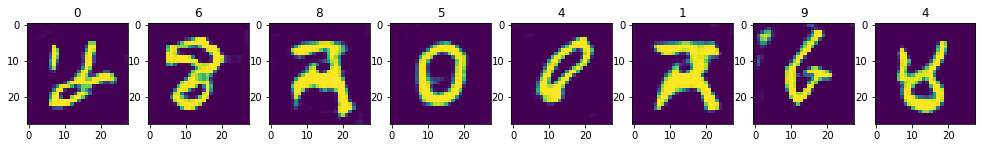


epoch is 119: discriminator loss is         1.0788592100143433, generator loss is 1.3647923469543457


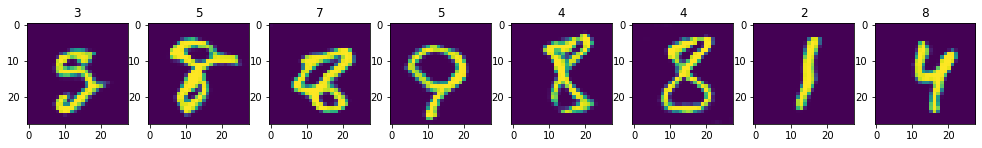


epoch is 139: discriminator loss is         1.044885277748108, generator loss is 1.3499748706817627


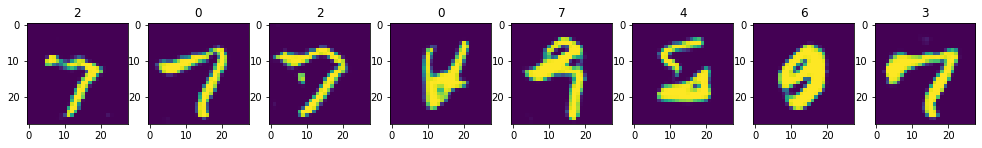


epoch is 159: discriminator loss is         0.9852939248085022, generator loss is 1.5508702993392944


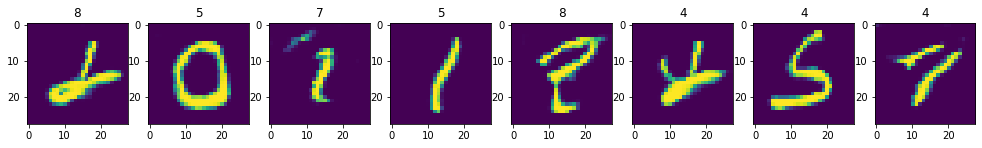


epoch is 179: discriminator loss is         1.0892294645309448, generator loss is 1.276970386505127


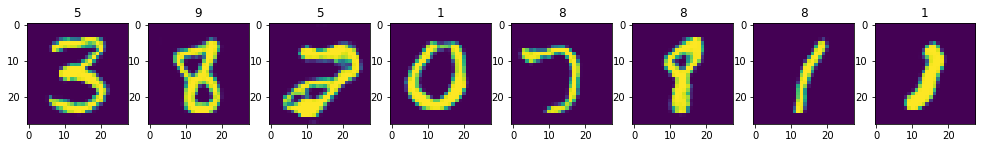


epoch is 199: discriminator loss is         1.095025658607483, generator loss is 1.2363715171813965


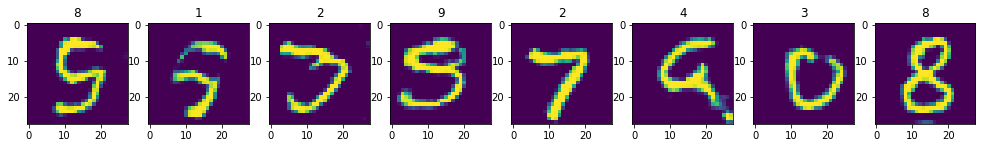

In [11]:
from tqdm.notebook import tnrange, tqdm_notebook

epoch_list = []
d_loss_list = []
g_loss_list = []



for epoch in tnrange(epochs):
    
    for t in range((int)(N / batch_size)):


        X_train_seg = X_train[t * batch_size: (t + 1) * batch_size].view(batch_size, channels, img_size, img_size)
        Y_train_seg = Y_train[t * batch_size: (t + 1) * batch_size]
        # print(f"{t * batch_size} - {(t + 1) * batch_size}")

        # feed generator with noise
        gen_labels = Variable(torch.cuda.LongTensor(np.random.randint(0, label_classes, batch_size))).cuda()
        fake = generator(gen_labels) # fake is a image
        
        # train discriminator
        # train real data
        discriminator_optimizer.zero_grad()
        real_pred, real_aux = discriminator(X_train_seg)
        loss_real = (adversarial_loss(real_pred, torch.ones(batch_size, 1).cuda())
            + auxiliary_loss(real_aux, Y_train_seg)) / 2
        # train fake data
        fake_pred, fake_aux = discriminator(fake.detach())
        loss_fake = (adversarial_loss(fake_pred, torch.zeros(batch_size, 1).cuda())
            + auxiliary_loss(fake_aux, gen_labels)) / 2
        loss_d = (loss_real + loss_fake) / 2
        loss_d.backward()
        discriminator_optimizer.step()

        # train generator
        generator_optimizer.zero_grad()
        val, l = discriminator(fake)
        loss_g = (adversarial_loss(val, torch.ones(batch_size, 1).cuda())
            + auxiliary_loss(l, gen_labels)) / 2
        loss_g.backward()
        generator_optimizer.step()

    epoch_list.append(epoch)
    d_loss_list.append(loss_d.item())
    g_loss_list.append(loss_g.item())

    if (epoch + 1) % 20 == 0:
        test_labels = \
            Variable(torch.cuda.LongTensor(np.random.randint(0, label_classes, 8))).cuda()
        fake = generator(test_labels)
        print(f"epoch is {epoch}: discriminator loss is \
        {loss_d.item()}, generator loss is {loss_g.item()}")
        show_generate_image(fake, test_labels)

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=d_loss_list, color='red', label='discriminator line', ax=ax)
sns.lineplot(x=epoch_list, y=g_loss_list, color='blue', label='generator line', ax=ax)
plt.title(f"loss against epoch")
plt.show()


=========================

In [20]:
from torchvision import datasets
import torchvision.transforms as transforms

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw




Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [21]:
for i, (imgs, labels) in enumerate(dataloader):
    print(labels)

tensor([0, 1, 7, 3, 1, 2, 1, 0, 5, 2, 0, 6, 6, 4, 0, 3, 1, 2, 2, 8, 2, 1, 2, 1,
        7, 1, 9, 3, 0, 4, 5, 3])
tensor([2, 1, 6, 2, 6, 9, 7, 8, 5, 4, 6, 3, 9, 6, 3, 7, 5, 9, 0, 7, 3, 9, 3, 1,
        1, 9, 2, 9, 7, 3, 4, 5])
tensor([3, 4, 4, 8, 1, 5, 7, 1, 6, 5, 0, 6, 5, 3, 3, 4, 1, 3, 7, 1, 6, 6, 1, 6,
        3, 7, 2, 7, 7, 1, 4, 2])
tensor([2, 9, 6, 4, 8, 9, 1, 1, 6, 0, 9, 6, 4, 5, 2, 1, 5, 8, 6, 2, 6, 8, 7, 4,
        4, 5, 0, 2, 1, 4, 2, 3])
tensor([6, 5, 8, 1, 0, 9, 8, 2, 8, 7, 9, 1, 3, 7, 3, 0, 0, 7, 6, 5, 4, 1, 2, 8,
        3, 7, 1, 7, 1, 6, 2, 3])
tensor([9, 5, 2, 7, 6, 2, 8, 2, 8, 5, 9, 5, 7, 6, 3, 6, 2, 8, 3, 8, 9, 4, 2, 0,
        3, 9, 4, 6, 1, 2, 9, 3])
tensor([6, 0, 2, 2, 9, 8, 1, 0, 3, 9, 7, 5, 7, 2, 3, 3, 0, 5, 0, 5, 3, 9, 9, 3,
        1, 2, 0, 0, 6, 7, 9, 2])
tensor([5, 6, 2, 9, 9, 4, 3, 1, 6, 6, 4, 4, 6, 0, 5, 8, 6, 7, 3, 6, 3, 4, 2, 9,
        1, 2, 1, 6, 9, 5, 1, 8])
tensor([8, 3, 8, 2, 3, 3, 3, 4, 2, 1, 5, 7, 5, 3, 5, 2, 9, 3, 6, 7, 7, 6, 8, 8,
        4, 2, 2,

KeyboardInterrupt: ignored

In [ ]:
label_emb = nn.Embedding(n_classes, latent_dim).cuda()

In [ ]:
label_emb(gen_labels).size()

torch.Size([64, 100])

In [ ]:
input = torch.mul(label_emb(gen_labels), z)
input.size()

torch.Size([64, 100])

In [ ]:
label_emb(torch.LongTensor([3, 7, 5, 7, 4, 3]).cuda())

tensor([[ 2.7215e-02,  7.8519e-01, -8.8001e-01,  2.1255e-01, -2.4295e-01,
         -8.5597e-01, -5.4428e-01,  7.2043e-01, -2.3116e-01,  8.9193e-01,
         -1.9086e-01,  2.4456e-01,  2.9121e-01,  6.8968e-02,  3.4306e-01,
          1.3845e+00, -1.6111e+00, -1.1383e+00, -1.2362e+00,  5.9456e-02,
          4.4886e-01, -1.3046e+00,  1.8611e-01,  1.1382e+00, -1.1620e+00,
         -7.1407e-01, -6.5871e-01,  2.5875e-01,  6.2464e-01, -3.5525e-02,
         -6.2551e-01,  3.2627e-01,  1.4171e-01,  1.1860e-02,  1.2237e+00,
         -8.1045e-01, -8.0309e-01, -1.2119e+00,  8.5478e-01, -1.0928e+00,
          1.4775e+00, -2.8349e-01,  7.8462e-02, -1.0319e+00, -8.6210e-01,
         -7.1445e-02, -5.9968e-01, -5.7613e-01,  1.5089e-01,  4.9831e-01,
         -1.2920e+00,  1.4540e+00, -1.9555e+00,  2.5548e-01, -1.4829e+00,
         -3.2472e-02,  4.3744e-01,  1.5100e+00, -3.6293e-01,  2.1843e+00,
          2.5614e-01,  1.1126e+00, -4.4586e-01,  1.0466e+00, -1.0846e+00,
         -6.5934e-01,  5.5246e-01, -1.